# [book](https://nbviewer.org/github/fastai/fastbook/blob/master/13_convolutions.ipynb)

# [Good Article To Visualize Convolutions](https://medium.com/towards-data-science/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)

# [Useful Link For Visualization](https://ezyang.github.io/convolution-visualizer/)

In [612]:
dependencies = [
    "kagtool",
    "kaggle",
    "fastai",
    "nbdev",
    "datasets"
]

!pip install -U {" ".join(dependencies)}

from fastai.imports import *

^C
ERROR: Operation cancelled by user


In [2]:
import gc

from fastai.imports import *
from fastai.vision.all import *

import matplotlib.pyplot as plt

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Loading An Image As A Tensor

### Image With Color Channels

In [ ]:
cifar_path = untar_data(URLs.CIFAR)
cifar_path.ls()

(#3) [Path('/Users/cactus/.fastai/data/cifar10/test'),Path('/Users/cactus/.fastai/data/cifar10/labels.txt'),Path('/Users/cactus/.fastai/data/cifar10/train')]

<Axes: >

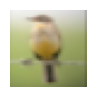

In [ ]:
bird = Image.open(cifar_path/'train'/'bird'/'144_bird.png')
show_image(bird)

In [ ]:
bird.shape

(32, 32)

We can access the channel after transforming the PILImage into a numpy array

In [ ]:
np.array(bird).shape

(32, 32, 3)

### Grayscale Images

`Image.open` loads image as rank-3 tensors

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
path.ls()

(#3) [Path('/Users/cactus/.fastai/data/mnist_sample/valid'),Path('/Users/cactus/.fastai/data/mnist_sample/labels.csv'),Path('/Users/cactus/.fastai/data/mnist_sample/train')]

<Axes: >

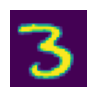

In [ ]:
im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3)

Note the difference with the bird image, this image has no color channel, so it's actually a grayscale image

In [ ]:
# be careful to do shape on the numpy array, not the image object
np.array(im3).shape

(28, 28)

# Convolutions 101

### A Kernel Is a Filter

In [ ]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

In [ ]:
im3_t = tensor(im3)
im3_t[0:3,0:3] * top_edge

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [ ]:
(im3_t[0:3,0:3] * top_edge).sum()

tensor(0.)

In [ ]:
df = pd.DataFrame(im3_t[:10,:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [ ]:
# there's a top edge around cell (4,6)
im3_t[4:7,6:9] * top_edge

tensor([[ -0.,  -0.,  -0.],
        [  0.,   0.,   0.],
        [254., 254., 254.]])

In [ ]:
# we do a sum to know if there's a top edge, the bigger the number the higher the probability
(im3_t[4:7,6:9] * top_edge).sum()

tensor(762.)

In [ ]:
# There's a right edge at cell 8,18. What does that give us?:
im3_t[7:10,17:20] * top_edge

tensor([[-254.,  -75.,   -0.],
        [   0.,    0.,    0.],
        [ 247.,   53.,    0.]])

In [ ]:
# that's not a top edge, so we got a low number
(im3_t[7:10,17:20] * top_edge).sum()

tensor(-29.)

### Applying A Kernel (Mask) To The Whole Image

That was cool, but we had to tell the computer where to detect the edge, first let's refactor our code to apply a kernel anywhere

In [ ]:
def apply_kernel(row, col, kernel):
    return (im3_t[row-1:row+2,col-1:col+2] * kernel).sum()

In [ ]:
apply_kernel(5,7,top_edge)

tensor(762.)

In [ ]:
# we can't apply a kernel at the very edge,
# because we don't have enough pixels,
# we will see how to solve this with padding later
try:
    apply_kernel(0,0,top_edge)
except Exception as e:
    print(e)

The size of tensor a (0) must match the size of tensor b (3) at non-singleton dimension 1


In [ ]:
apply_kernel(1,1,top_edge)

tensor(0.)

### Convolution = Applying The Kernel In A Sliding Window Fashion

In [ ]:
def my_convolution(rng, filter):
    return tensor([[apply_kernel(i,j,filter) for j in rng] for i in rng])

<Axes: >

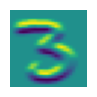

In [ ]:
# apply top-edge kernel to whole image, again we can't go to the every edge, but we will solve this later
rng = range(1,27)
top_edge3_convo = my_convolution(rng, filter=top_edge)
show_image(top_edge3_convo)

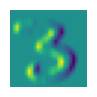

In [ ]:
left_edge = tensor([[-1,0,1],
                    [-1,0,1],
                    [-1,0,1]]).float()

left_edge3 = my_convolution(rng, filter=left_edge)

show_image(left_edge3);

As you can see, applying different kernels to the same images result in different convolutions
> or more simply different filters give different images!

# Using Conv2D

### Let's work with a real batch of data instead of a single image

In [ ]:
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

dls = mnist.dataloaders(path)
xb,yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

In [ ]:
xb,yb = to_cpu(xb),to_cpu(yb)

In [ ]:
F.conv2d??

Docstring:
conv2d(input, weight, bias=None, stride=1, padding=0, dilation=1, groups=1) -> Tensor

Applies a 2D convolution over an input image composed of several input
planes.

This operator supports :ref:`TensorFloat32<tf32_on_ampere>`.

See :class:`~torch.nn.Conv2d` for details and output shape.

Note:
    In some circumstances when given tensors on a CUDA device and using CuDNN, this operator may select a nondeterministic algorithm to increase performance. If this is undesirable, you can try to make the operation deterministic (potentially at a performance cost) by setting ``torch.backends.cudnn.deterministic = True``. See :doc:`/notes/randomness` for more information.

Note:
    This operator supports complex data types i.e. ``complex32, complex64, complex128``.


Args:
    input: input tensor of shape :math:`(\text{minibatch} , \text{in\_channels} , iH , iW)`
    weight: filters of shape :math:`(\text{out\_channels} , \frac{\text{in\_channels}}{\text{groups}} , kH , kW)`
    bias

### Why Conv2d Expects a Rank-4 Tensor - NCHW

__F.conv2d expects a rank-4 tensor because...__:
- it can apply multiple kernels at the same time! so list of kernels (channels?)
- it can apply those kernels on a whole batch at the same time!

In [ ]:
# So F.conv2d needs a batch of images
# Input should be of format N(batch) * C * H * W
xb.shape
# perfect we already got what we want

torch.Size([64, 1, 28, 28])

In [ ]:
# Let's make a list of kernels to apply instead of just one kernel
right_edge = left_edge.flip(dims=[1])

vertical_edges = torch.stack([left_edge, right_edge])
vertical_edges.shape

torch.Size([2, 3, 3])

In [ ]:
try:
    F.conv2d(xb, vertical_edges)
except Exception as e:
    print(e)

expected stride to be a single integer value or a list of 1 values to match the convolution dimensions, but got stride=[1, 1]


In [ ]:
# Kernel (so the weight) should be of format C_out * C_in * H * W
# channel_in    = should match the channel of the input
# channel_out   = is the number of filters we want to apply
vertical_edges.unsqueeze(1).shape

torch.Size([2, 1, 3, 3])

In [ ]:
batch_features = F.conv2d(xb, vertical_edges.unsqueeze(1))
batch_features.shape
# why is the 2nd dimension 2? Because we applied 2 filters! (vertical edges = 2)

torch.Size([64, 2, 26, 26])

### F.conv2d Outputs a Batch Of Filters!

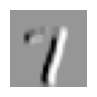

In [ ]:
# Let's switch color to grayscale to better see what's going on
plt.rc('image', cmap='Greys')

# looking at example 64, we access the first output channel for the left edge
show_image(batch_features[2][0]);

### Changing The Number Of Output Channels

- What if we wanted to have 1 output channel instead of two?
- What if we wanted to have 1 filter not 2

In [ ]:
# 1. Even if we want one kernel, we need to make a list of 1 kernel, cuz that's what conv2d wants
# 2. We need to make sure the channel is the same as the input's channel (it was 1 so let's use 1 too)
left_edge.unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 3, 3])

### How Does It Work With Colors?

In [ ]:
tensor(Image.open(cifar_path/'train'/'bird'/'144_bird.png')).shape

torch.Size([32, 32, 3])

(torch.Size([3, 32, 32]), <Axes: >)

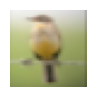

In [ ]:
# # we need NCHW format
# bird = bird.permute(2,0,1).unsqueeze(-1)
# bird.shape

# or just use fastai image2tensor
bird = image2tensor(Image.open(cifar_path/'train'/'bird'/'144_bird.png'))
bird.shape, show_image(bird)

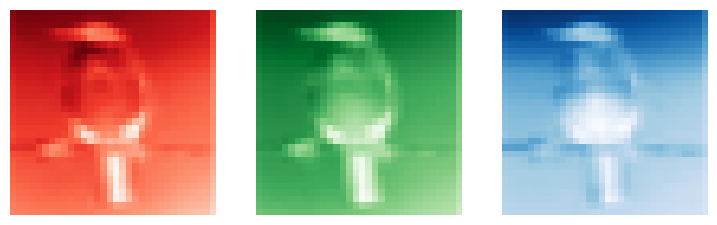

In [ ]:
_,axs = subplots(1,3)
for b,ax,color in zip(bird,axs,('Reds','Greens','Blues')):
    show_image(b, ax=ax, cmap=color)

In [ ]:
# Define a left-edge detection kernel
left_kernel = torch.tensor([[-1, 0, 1],
                            [-1, 0, 1],
                            [-1, 0, 1]]).float().unsqueeze(0).unsqueeze(0)

# Since our input has 3 channels, we need 3 kernels, one for each input channel
# Here we repeat the kernel for each channel
left_kernel = left_kernel.repeat(3, 1, 1, 1)  # Now the shape is (3, 1, 3, 3)
left_kernel.shape

torch.Size([3, 1, 3, 3])

In [ ]:
vertical_edges.unsqueeze(1).repeat(3, 1, 1, 1).shape

torch.Size([6, 1, 3, 3])

In [ ]:
try:
    features = F.conv2d(bird, vertical_edges.unsqueeze(1).repeat(3, 1, 1, 1), padding=1, groups=3)
    features.shape
except Exception as e:
    print(e)

In [ ]:
bird = bird.float() / 255
features = F.conv2d(bird, left_kernel, padding=1, groups=3)
features.shape

torch.Size([3, 32, 32])

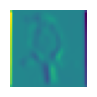

In [ ]:

# looking at example 64, we access the first output channel for the left edge
show_image(features[0]);

Not very illustrative, but basically we got the left edge filter applied to each channel of the image

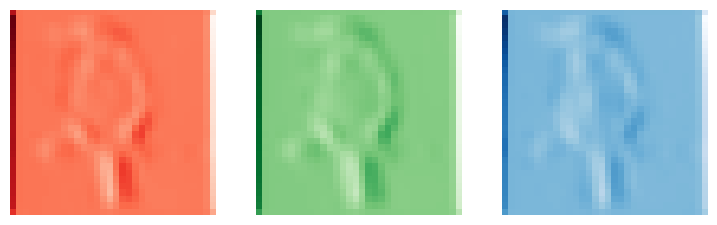

In [ ]:
_,axs = subplots(1,3)
for b,ax,color in zip(features,axs,('Reds','Greens','Blues')):
    show_image(b, ax=ax, cmap=color)

# Understanding Striding And Padding

### Padding

In [ ]:
# recap of the input shape
xb.shape

torch.Size([64, 1, 28, 28])

In [ ]:
F.conv2d(xb, vertical_edges.unsqueeze(1)).shape

torch.Size([64, 2, 26, 26])

why does the result shrink?
- The kernel can only slide so much in the image, to find out how many times it can slide you do `width - kernel_sz = slide_times`
- For example `28 - 3 = 25 times`
- But we are talking about intervals here, we want to know how many positions can the kernel be in, it can be in `25 + 1 (starting position)` so 26
- Boom answer is 26!

What if we add padding?

In [ ]:
F.conv2d(xb, vertical_edges.unsqueeze(1), padding=1).shape

torch.Size([64, 2, 28, 28])

The calcul is exactly the same, but with padding we effectively made the image bigger:
- We 1 padding to each side so `28 + (2*1padding)`, image is now `30` instead of 28
- Same calculation as before `30 - 3 (kernel size) + 1 = 28
- Boom answer is 28!

the usual padding is 1, and the usual kernel size is 3

### Stride

Stride let us downsample the image, the simplest way to understand this, is imagining doing many conv with strides, this will give u a collection of images that are smaller and smaller and smaller, like thumbnails!

stride 1 is the default, so it also reduces the image because the kernel is kinda mapping a higher dimension into a smaller dimension

In [ ]:
F.conv2d(xb, vertical_edges.unsqueeze(1), padding=1, stride=1).shape

torch.Size([64, 2, 28, 28])

what if we do stride 2?

In [ ]:
F.conv2d(xb, vertical_edges.unsqueeze(1), padding=1, stride=2).shape

torch.Size([64, 2, 14, 14])

stride 2 are useful for decreasing the size of the output, it's usually what we are looking for in our model, we want to compress information

stride 3

In [ ]:
F.conv2d(xb, vertical_edges.unsqueeze(1), padding=1, stride=3).shape

torch.Size([64, 2, 10, 10])

# Neural Net To Recognize If It's a 7 or not

In [ ]:
input_pixels = 28*28
hidden_size = 30
# note that we have 1 output class for now
output_classes = 1

simple_net = nn.Sequential(
    nn.Linear(input_pixels, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_classes)
)
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

# CNN To Recognize If It's a 7 or not

In [ ]:
# note that we don't have input size!!!!
hidden_size = 30
# note that we have 1 output class for now
output_classes = 1

broken_cnn = sequential(
    nn.Conv2d(1, hidden_size, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(hidden_size, 1, kernel_size=3, padding=1)
)
broken_cnn

Sequential(
  (0): Conv2d(1, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(30, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

### How many weight is there per layer?

In [ ]:
broken_cnn[0].weight.shape, broken_cnn[0].bias.shape

(torch.Size([30, 1, 3, 3]), torch.Size([30]))

In [ ]:
# so that's 
30 * 1 * 3 * 3 + 30

300

### How To Go From Convolutions Layers To Classification Activation?

Let's see what happens if we pass our data through our model

In [ ]:
xb.shape, broken_cnn(xb).shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 1, 28, 28]))

It give us an image for each image!!! That's not what we want...

We want to do classification, so we should end up with a single number per image, we need to compress information from the input to the final layers of the model

We need a single output activation per image, not a 28x28 map of activations

- We can solve the compressing by using stride 2 convolutions, they will help us reduce the dimensions at each layer
- we need to use enough stride-2 convolutions so that the final layer size is 1

In [ ]:
def conv(inputs_channels, output_channels, kernel_size=3, act=True):
    res = nn.Conv2d(inputs_channels, output_channels, stride=2, kernel_size=kernel_size, padding=kernel_size//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

- How do you decide number of inputs and outputs?
- What's the activation map at each layer, how many weights will we have?

How do you decide number of inputs and outputs? Inputs:
- our inputs has one channel, it's grayscale, so we use the same value of 1
- For the outputs, we can just decide by ourselves how many weights we want per cell
- It's the same thing as saying beachin each cell we want 4 latent factors
- Then as we go one, the next layer will take as inputs the outputs of the previous layer

__Why do we need to double the number of weights at each layer?__

There are two ways to interpret this:
- First way: as we reduce spatial dimension, we want to find more meaningful and abstract features, for example if in the first layer we want to detect edges and stuff, the latter kernel maybe don't even look for physical features but try to interpret pixels in terms of latent factors, in terms of texture, concepts, types of objects, maybe even emotion or connotation, who knows!
- Second way: yes we reduce the amount of cells a convo layer sees as it slides through the result of the preceding layer, but it also means, the convo layer is effectively seeing more of the input at once, it slides less because the inputs is smaller, so it sees more, and because it sees more it goes back to the first point 👆 it should interpret more?

In [ ]:
simple_cnn = sequential(
    # activation map / features map / convolution = same meaning!
    conv(1, 4),                 # after this, activation map = 28x28/stride2, so 14x14  = 196 cells
    conv(4, 8),                 # after this, activation map = 14x14/stride2, so 7x7    = 49 cells
    conv(8, 16),                # after this, activation map = 4x4                      = 16 cells
    conv(16, 32),               # after this, activation map = 2x2                      = 4 cells
    conv(32, 2, act=False),     # after this, activation map = 1x1, why don't we do output=1?
    Flatten(),
)
simple_cnn

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(32, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): fastai.layers.Flatten(full=False)
)

In [ ]:
simple_cnn(xb).shape
# that's better! we end up with a single classification

torch.Size([64, 1])

In [ ]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(32, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): fastai.layers.Flatten(full=False)
)

In [ ]:
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.061414,0.030110,0.987733,00:09
1,0.019491,0.016924,0.994603,00:09


# Understanding Weights and Activations in a CNN

### Weights

__The weight are independent of the inputs size__

To recap that's our model

In [ ]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(32, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): fastai.layers.Flatten(full=False)
)

Let's take a look at how many weights there are in the first layer

In [ ]:
learn.model[0][0].weight.shape, learn.model[0][0].bias.shape

(torch.Size([4, 1, 3, 3]), torch.Size([4]))

In [ ]:
(4 * 1 * 3 * 3) + 4

40

So the `number of weights = weights_wanted/output_channels/features * input_channels * kernel_size + bias`

### Activations

__The activations depend on the input size!__

Let's recap our model

In [ ]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

What does the output of the first layer represent?

It's the size of the convolutions, so it's the activations

Why is the output shape 64 x 4 x 14 x 14?

This is the input

In [ ]:
dls.one_batch()[0].shape

torch.Size([64, 1, 28, 28])

And this is the kernel

In [ ]:
learn.model[0][0]

Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

So we got:

In [ ]:
stride = learn.model[0][0].stride[0]
# kernel_size = learn.model[0][0].kernel_size[0]
input_size = dls.one_batch()[0].shape[-1]
print('input_size =', input_size)
print('stride =', stride)

input_size = 28
stride = 2


In [ ]:
#To know what is the size of the output (activation) we need to:
input_size // stride

14

In [ ]:
14 * 14
# so the first layer got 196 activations!

196

### Recap

In [ ]:
import numpy as np
import pandas as pd

def display_learn_model_stats(learn):
    # Initialize the data dictionary
    data = {
        'Layer': [],
        'Weights': [],
        'Conv Size': [],
        'Activation Cells': [],
        'Multiplications': []
    }

    # Get initial conv_size from the data loader
    conv_size = dls.one_batch()[0].shape[-1]

    # Store the previous activation cells, initialized to the input size
    prev_activation_cells = conv_size ** 2

    # Iterate through the model layers
    for i, layer in enumerate(learn.model.children()):
        # Check if the layer is a Sequential or Conv2d
        if isinstance(layer, nn.Sequential):
            conv_layer = layer[0]
        elif isinstance(layer, nn.Conv2d):
            conv_layer = layer
        else:
            continue
        
        if not isinstance(conv_layer, nn.Conv2d):
            continue
        
        layer_name = f'Layer {i+1}'
        data['Layer'].append(layer_name)
        
        # Calculate weights (number of parameters in the convolutional layer)
        weights = np.prod(conv_layer.weight.shape) + conv_layer.bias.shape[0]
        data['Weights'].append(weights)
        
        # Update conv_size based on the current layer parameters
        kernel_size = conv_layer.kernel_size[0]
        stride = conv_layer.stride[0]
        padding = conv_layer.padding[0]
        
        conv_size = (conv_size - kernel_size + 2 * padding) // stride + 1
        data['Conv Size'].append(conv_size)
        
        # Calculate activation cells (number of cells in the feature map)
        activation_cells = conv_size ** 2
        data['Activation Cells'].append(activation_cells)
        
        # Calculate multiplications
        multiplications = weights * prev_activation_cells
        data['Multiplications'].append(multiplications)
        
        # Update prev_activation_cells for the next iteration
        prev_activation_cells = activation_cells

    # Create a DataFrame from the data dictionary
    return pd.DataFrame(data)


display_learn_model_stats(learn)

,Layer,Weights,Conv Size,Activation Cells,Multiplications
0,Layer 1,40,14,196,31360
1,Layer 2,296,7,49,58016
2,Layer 3,1168,4,16,57232
3,Layer 4,4640,2,4,74240
4,Layer 5,578,1,1,2312


# Getting Real - a CNN to classify 10 digits

In [ ]:
path = untar_data(URLs.MNIST)

In [ ]:
Path.BASE_PATH = path

In [ ]:
path.ls()

(#3) [Path('.DS_Store'),Path('training'),Path('testing')]

In [ ]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

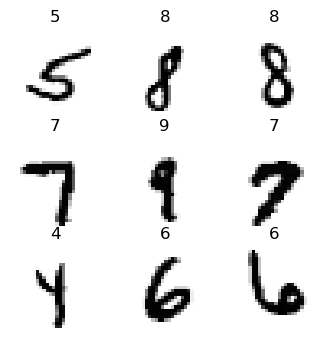

In [ ]:
dls.show_batch(max_n=9, figsize=(4,4))

In [722]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

In [723]:
def simple_cnn():
    return sequential(
        conv(1 ,8, ks=5),        #next inputs = 14x14
        conv(8 ,16),             #next inputs = 7x7
        conv(16,32),             #next inputs = 4x4
        conv(32,64),             #next inputs = 2x2
        conv(64,10, act=False),  #next inputs = 1x1
        Flatten(),
    )

In [724]:
learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.099620,0.060225,0.982500,00:56
1,0.058493,0.038122,0.988400,00:59
2,0.028171,0.028618,0.991800,00:56
